Uses regular phase_desc

- Compute semantic similarity between abstracts and phase descriptions (from phase_desc.json)
- Combine similarity with query-based priors to assign phases
- Analyze phase distributions and confidence

Results:
- Semantic phase probabilities are generally low and close together → weak semantic separation
- Phase 3 (Optimization) becomes dominant for most abstracts when using normal phase_desc.
- Phase 1 is equally dominant when using extended phase_desc.
- Query-based priors strongly influence the final phase assignment, since the semantic separation is so weak.
- The written phase descriptions also becomes too influential. 

Regarding the results:
- This is not necessarily wrong (that most ML-for-manufacturing research focuses on optimization)
- However, clearer and more detailed phase descriptions are likely needed
- A bibliometric clustering step should also be introduced before lifecycle phase mapping to reveal natural topic structure in the literature

In [1]:
# Imports

import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
phase_config_path = Path("../../phases/phase_desc.json")
save_path = processed_abstracts_path / "semantic_analysis"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
# Load phase descriptions from JSON

with phase_config_path.open("r", encoding="utf-8") as f:
    phases = json.load(f)

phase_ids = list(phases.keys())
phase_texts = [phases[p]["description"] for p in phase_ids]

for pid, ptext in zip(phase_ids, phase_texts):
    print(f"{pid}: {ptext[:80]}...")


phase_1: Work on early product or production planning: market and demand analysis, produc...
phase_2: Work on designing and developing products or running production processes: proce...
phase_3: Work on improving existing processes or systems using collected data: monitoring...
phase_4: Work on how products are used in the field or reused: in-service monitoring, usa...


In [6]:
# Phase priors per query_id
# Format: [Phase1_Planning, Phase2_Development/Production, Phase3_Optimization, Phase4_Use/Reuse]

phase_priors = {
    # Use / Reuse — dominant Phase 4
    "ml_inservice_monitoring":       [0.05, 0.20, 0.35, 0.40],
    "ml_remanufacturing":            [0.05, 0.10, 0.15, 0.70],
    "ml_disassembly":                [0.05, 0.25, 0.20, 0.50],
    "ml_end_of_life":                [0.05, 0.10, 0.15, 0.70],
    "ml_recycling_manufacturing":    [0.05, 0.30, 0.20, 0.45],
    "ml_sustainability_product":     [0.30, 0.10, 0.10, 0.50],

    # Very broad — spans production & optimization
    "ml_manufacturing":              [0.10, 0.45, 0.40, 0.05],

    # Planning phase focus
    "ml_planning_production":        [0.75, 0.15, 0.10, 0.00],
    "ml_product_design":             [0.80, 0.15, 0.05, 0.00],
    "ml_plm":                        [0.40, 0.10, 0.15, 0.35],  # lifecycle both ends

    # Development / Production execution focus
    "ml_product_development":        [0.20, 0.60, 0.20, 0.00],
    "ml_defect_detection":           [0.10, 0.65, 0.25, 0.00],
    "ml_quality_control":            [0.05, 0.55, 0.40, 0.00],
    "ml_automation":                 [0.05, 0.70, 0.25, 0.00],
    "ml_robotics_production":        [0.05, 0.75, 0.20, 0.00],

    # Supply chain → planning weighted, but still operational relevance
    "ml_supply_chain":               [0.45, 0.35, 0.15, 0.05],

    # Optimization focused
    "ml_manufacturing_optimization": [0.05, 0.25, 0.70, 0.00],
    "ml_production_optimization":    [0.05, 0.25, 0.70, 0.00],
    "ml_process_optimization":       [0.05, 0.25, 0.70, 0.00],
    "ml_process_control":            [0.05, 0.20, 0.75, 0.00],
    "ml_process_modeling":           [0.10, 0.20, 0.70, 0.00],
    "ml_predictive_maintenance":     [0.05, 0.20, 0.60, 0.15],
    "ml_anomaly_detection_production":[0.05, 0.20, 0.70, 0.05],

    # Use / Reuse specific — RUL informs lifetime while still in operation
    "ml_rul":                        [0.05, 0.15, 0.30, 0.50],
}



def get_phase_prior(query_id):
    # Return a valid probability vector for the query
    prior = phase_priors.get(query_id)
    if prior is None:
        # Default weakly uniform prior if unknown query_id
        prior = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)
    else:
        prior = np.array(prior, dtype=float)
        prior = prior / prior.sum()
    return prior


In [7]:
# Define embedding and similarity helpers (to be implemented with your chosen model)

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")  # In use
light_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

def get_embedding(text):
    """
    Return a vector 
    ing for the given text.
    Uses a SentenceTransformer model.
    """
    if not isinstance(text, str):
        text = ""
    emb = model.encode(
        text,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return emb

def cosine_similarity(a, b):
    # Compute cosine similarity between two 1D vectors
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


In [8]:
# Precompute embeddings for all phase descriptions

phase_embeddings = []
for pid, ptext in zip(phase_ids, phase_texts):
    emb = get_embedding(ptext)
    phase_embeddings.append(emb)

phase_embeddings = np.vstack(phase_embeddings)
phase_embeddings.shape


(4, 768)

In [9]:
# Compute semantic phase scores for each abstract with progress bar

from tqdm import tqdm

sim_cols = ["sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4"]

# Initialize columns
for col in sim_cols:
    df[col] = np.nan

batch_size = 512  # Adjust based on GPU memory

for start in tqdm(range(0, len(df), batch_size), desc="Embedding abstracts"):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    sims = []
    for text in batch["clean_abs"].astype(str).tolist():
        e_abs = get_embedding(text)
        sim_vec = [cosine_similarity(e_abs, pe) for pe in phase_embeddings]
        sims.append(sim_vec)

    sims = np.array(sims)
    exp_sims = np.exp(sims - sims.max(axis=1, keepdims=True))
    probs = exp_sims / exp_sims.sum(axis=1, keepdims=True)

    df.loc[batch.index, sim_cols] = probs

print("Semantic phase scores computed.")
df[sim_cols].head()


Embedding abstracts:   2%|▏         | 1/65 [00:11<12:24, 11.63s/it]


KeyboardInterrupt: 

In [ ]:
# Combine query priors and semantic scores into final phase probabilities

alpha = 0.0 # Weight on priors (0=only semantics, 1=only priors)

final_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df[final_cols] = np.nan

primary_labels = []
secondary_labels = []

for idx, row in df.iterrows():
    prior = get_phase_prior(row["query_id"])
    sem = row[sim_cols].values.astype(float)

    # Safety check for NaN
    if np.any(~np.isfinite(sem)):
        sem = np.ones(4) / 4.0

    combined = alpha * prior + (1 - alpha) * sem
    combined = combined / combined.sum()

    df.loc[idx, final_cols] = combined

    # Determine primary and secondary phases
    order = np.argsort(-combined)  # descending
    primary = order[0] + 1  # 1-based phase index
    secondary = order[1] + 1

    primary_labels.append(primary)
    secondary_labels.append(secondary)

df["primary_phase"] = primary_labels
df["secondary_phase"] = secondary_labels

print("Final phase probabilities and labels added.")
df[["query_id", "primary_phase", "secondary_phase"] + final_cols].head()


Final phase probabilities and labels added.


,query_id,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4
3373,ml_end_of_life,4,1,0.255349,0.235995,0.234561,0.274096
3374,ml_end_of_life,4,3,0.240306,0.235502,0.250155,0.274037
3387,ml_end_of_life,3,4,0.241560,0.227182,0.270291,0.260968
3388,ml_end_of_life,3,2,0.240157,0.253849,0.265071,0.240924
3389,ml_end_of_life,4,3,0.226355,0.226007,0.260305,0.287334


In [ ]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_phases.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with phases to: {out_path}")


Saved dataset with phases to: ../../data/processed/abstracts/semantic_analysis/abstracts_with_phases.csv


In [ ]:
# Save dataset with just one phase-column

# Compute single phase column based on highest probability
phase_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df["phase"] = df[phase_cols].idxmax(axis=1).str.extract('(\d+)').astype(int)

# Drop old phase columns
df_min = df.drop(columns=phase_cols + [
    "sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4",
    "primary_phase", "secondary_phase"
])

# Save minimal dataset
out_path_min = save_path / "abstracts_min_phases.csv"
df_min.to_csv(out_path_min, index=False)

print(f"Saved minimal dataset with single phase column to: {out_path_min}")

Saved minimal dataset with single phase column to: ../../data/processed/abstracts/semantic_analysis/abstracts_min_phases.csv


primary_phase
1     4288
2     2108
3    24053
4     2681
Name: count, dtype: int64


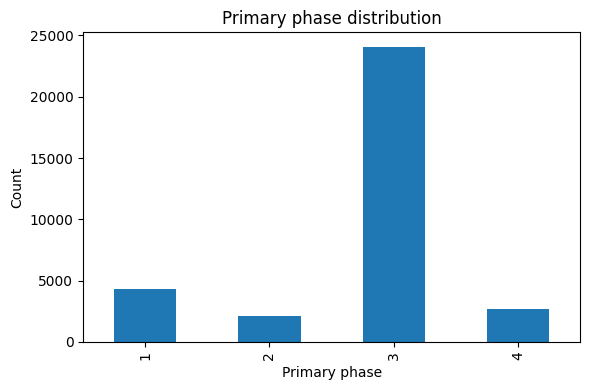

In [ ]:
# Plot primary phase distribution

phase_counts = df["primary_phase"].value_counts().sort_index()
print(phase_counts)

plt.figure(figsize=(6,4))
phase_counts.plot(kind="bar")
plt.xlabel("Primary phase")
plt.ylabel("Count")
plt.title("Primary phase distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Inspect phase distribution per query_id

phase_query_ct = pd.crosstab(df["query_id"], df["primary_phase"], normalize="index")
phase_query_ct = phase_query_ct.rename(columns=lambda x: f"phase_{x}")

phase_query_ct.head(25)


primary_phase,phase_1,phase_2,phase_3,phase_4
query_id,,,,
ml_anomaly_detection_production,0.003279,0.004918,0.981967,0.009836
ml_automation,0.117939,0.231913,0.598612,0.051536
ml_defect_detection,0.019672,0.047541,0.881967,0.050820
ml_disassembly,0.088561,0.158672,0.638376,0.114391
ml_end_of_life,0.019608,0.000000,0.254902,0.725490
ml_inservice_monitoring,0.036585,0.021951,0.858537,0.082927
ml_manufacturing,0.133527,0.101627,0.670155,0.094692
ml_manufacturing_optimization,0.305384,0.075750,0.549786,0.069081
ml_planning_production,0.282864,0.021714,0.646127,0.049296


In [ ]:
# Show queries most dominated by each phase

for p in [1, 2, 3, 4]:
    col = f"phase_{p}"
    print(f"\nTop queries for {col}:")
    display(phase_query_ct[col].sort_values(ascending=False).head(10))



Top queries for phase_1:


query_id
ml_supply_chain                  0.333805
ml_manufacturing_optimization    0.305384
ml_planning_production           0.282864
ml_product_design                0.240594
ml_product_development           0.227913
ml_process_optimization          0.178322
ml_remanufacturing               0.141414
ml_production_optimization       0.137697
ml_manufacturing                 0.133527
ml_sustainability_product        0.131980
Name: phase_1, dtype: float64


Top queries for phase_2:


query_id
ml_robotics_production           0.343923
ml_automation                    0.231913
ml_disassembly                   0.158672
ml_manufacturing                 0.101627
ml_process_optimization          0.099650
ml_remanufacturing               0.080808
ml_manufacturing_optimization    0.075750
ml_product_design                0.074257
ml_quality_control               0.066813
ml_plm                           0.061135
Name: phase_2, dtype: float64


Top queries for phase_3:


query_id
ml_anomaly_detection_production    0.981967
ml_rul                             0.970107
ml_predictive_maintenance          0.967213
ml_defect_detection                0.881967
ml_process_control                 0.870515
ml_inservice_monitoring            0.858537
ml_process_modeling                0.835637
ml_quality_control                 0.818182
ml_production_optimization         0.795534
ml_plm                             0.746725
Name: phase_3, dtype: float64


Top queries for phase_4:


query_id
ml_end_of_life                0.725490
ml_recycling_manufacturing    0.650485
ml_sustainability_product     0.414975
ml_remanufacturing            0.414141
ml_product_design             0.206931
ml_supply_chain               0.186704
ml_robotics_production        0.158840
ml_product_development        0.147247
ml_disassembly                0.114391
ml_manufacturing              0.094692
Name: phase_4, dtype: float64

In [ ]:
# Compute confidence metrics for phase assignment

df["phase_max_prob"] = df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].max(axis=1)

# Gap between primary and secondary phases
sorted_probs = np.sort(df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].values, axis=1)
df["phase_margin"] = sorted_probs[:, -1] - sorted_probs[:, -2]

df[["primary_phase", "secondary_phase", "phase_max_prob", "phase_margin"]].describe()


,primary_phase,secondary_phase,phase_max_prob,phase_margin
count,33130.000000,33130.000000,33130.000000,3.313000e+04
mean,2.758436,2.272683,0.273145,2.196463e-02
std,0.777133,1.200915,0.013243,1.822680e-02
min,1.000000,1.000000,0.250654,1.812395e-07
25%,3.000000,1.000000,0.262806,7.097391e-03
50%,3.000000,2.000000,0.270541,1.731391e-02
75%,3.000000,4.000000,0.281322,3.278294e-02
max,4.000000,4.000000,0.332371,1.084467e-01


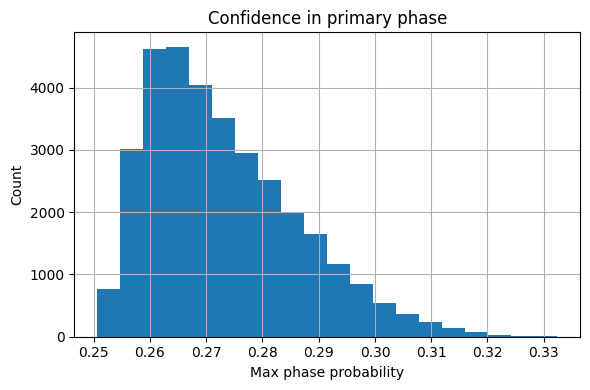

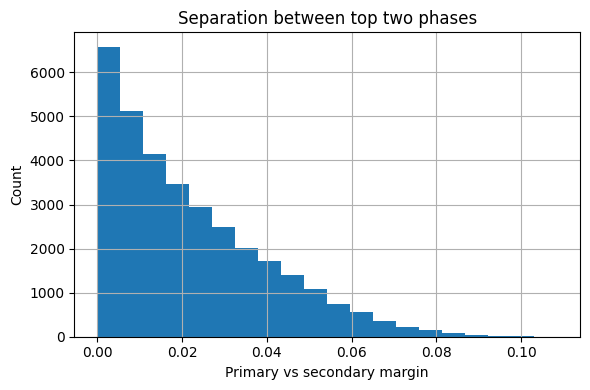

In [ ]:
# Plot distributions of confidence and margin

plt.figure(figsize=(6,4))
df["phase_max_prob"].hist(bins=20)
plt.xlabel("Max phase probability")
plt.ylabel("Count")
plt.title("Confidence in primary phase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df["phase_margin"].hist(bins=20)
plt.xlabel("Primary vs secondary margin")
plt.ylabel("Count")
plt.title("Separation between top two phases")
plt.tight_layout()
plt.show()


In [ ]:
# Inspect low-confidence samples

low_conf_mask = df["phase_max_prob"] < 0.5
print(f"Low-confidence abstracts (<0.5): {low_conf_mask.sum()}")

df_low_conf = df[low_conf_mask].sort_values("phase_max_prob").head(20)
df_low_conf[[
    "query_id",
    "doi",
    "primary_phase",
    "secondary_phase",
    "phase_p1",
    "phase_p2",
    "phase_p3",
    "phase_p4",
    "clean_abs"
]]


Low-confidence abstracts (<0.5): 33130


,query_id,doi,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4,clean_abs
2998,ml_defect_detection,10.1117/12.2524915,4,3,0.249362,0.249721,0.250264,0.250654,Downloading of the abstract is permitted for p...
6478,ml_manufacturing,10.1007/s12008-024-01836-9,4,3,0.249393,0.249756,0.250139,0.250712,Advancement of intelligent and computational t...
22922,ml_manufacturing_optimization,10.3788/CJL231577,2,4,0.248566,0.250712,0.250159,0.250563,All rights reserved.Significance Laser additiv...
36053,ml_process_modeling,10.1088/1361-6439/ab7322,2,3,0.249673,0.250888,0.250030,0.249409,Nanosecond-pulsed laser ablation is often acco...
20554,ml_manufacturing,10.23919/ICEP.2017.7939383,4,2,0.248886,0.250301,0.249923,0.250890,"Achieving required performance, quality and re..."
41747,ml_production_optimization,10.11975/j.issn.1002-6819.202401161,4,1,0.250461,0.248934,0.249703,0.250902,All rights reserved.Fragrant pears have been o...
17659,ml_manufacturing,10.1109/ICMLA52953.2021.00219,3,4,0.249841,0.248221,0.250975,0.250963,Surface roughness plays an important role in a...
23003,ml_manufacturing_optimization,10.3390/met14030282,2,3,0.248026,0.250984,0.250807,0.250183,This study advances foundational knowledge reg...
24118,ml_manufacturing_optimization,10.1007/978-981-19-1142-2_38,3,1,0.250563,0.249689,0.250987,0.248761,"Currently, industries and businesses are adopt..."
11550,ml_manufacturing,10.1007/978-981-97-0730-0_21,3,2,0.247295,0.250900,0.250995,0.250810,2024.One of the key industrial technologies us...


In [ ]:
# Aggregate mean phase probabilities per query_id

phase_prob_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
query_phase_means = df.groupby("query_id")[phase_prob_cols].mean()

query_phase_means.head()


,phase_p1,phase_p2,phase_p3,phase_p4
query_id,,,,
ml_anomaly_detection_production,0.235607,0.238396,0.293503,0.232494
ml_automation,0.246051,0.251264,0.263393,0.239292
ml_defect_detection,0.243621,0.246066,0.268482,0.241831
ml_disassembly,0.243910,0.246916,0.263067,0.246106
ml_end_of_life,0.242902,0.231459,0.253266,0.272373


In [ ]:
# Show queries with highest mean probability for each phase

for i, col in enumerate(phase_prob_cols, start=1):
    print(f"\nTop queries by mean {col}:")
    display(query_phase_means[col].sort_values(ascending=False).head(10))



Top queries by mean phase_p1:


query_id
ml_planning_production           0.257440
ml_supply_chain                  0.255317
ml_manufacturing_optimization    0.253593
ml_production_optimization       0.252013
ml_process_optimization          0.251201
ml_product_design                0.250124
ml_product_development           0.249983
ml_sustainability_product        0.249179
ml_robotics_production           0.248415
ml_process_modeling              0.247853
Name: phase_p1, dtype: float64


Top queries by mean phase_p2:


query_id
ml_robotics_production           0.252750
ml_automation                    0.251264
ml_process_optimization          0.247824
ml_disassembly                   0.246916
ml_manufacturing_optimization    0.246256
ml_defect_detection              0.246066
ml_manufacturing                 0.245311
ml_quality_control               0.245113
ml_product_design                0.244482
ml_process_control               0.244431
Name: phase_p2, dtype: float64


Top queries by mean phase_p3:


query_id
ml_anomaly_detection_production    0.293503
ml_predictive_maintenance          0.284562
ml_rul                             0.281676
ml_process_control                 0.277949
ml_inservice_monitoring            0.274244
ml_process_modeling                0.274038
ml_production_optimization         0.270716
ml_quality_control                 0.270047
ml_defect_detection                0.268482
ml_planning_production             0.266201
Name: phase_p3, dtype: float64


Top queries by mean phase_p4:


query_id
ml_end_of_life                0.272373
ml_recycling_manufacturing    0.264294
ml_sustainability_product     0.257904
ml_remanufacturing            0.257628
ml_rul                        0.249040
ml_product_design             0.247838
ml_supply_chain               0.247600
ml_product_development        0.247374
ml_disassembly                0.246106
ml_inservice_monitoring       0.245731
Name: phase_p4, dtype: float64

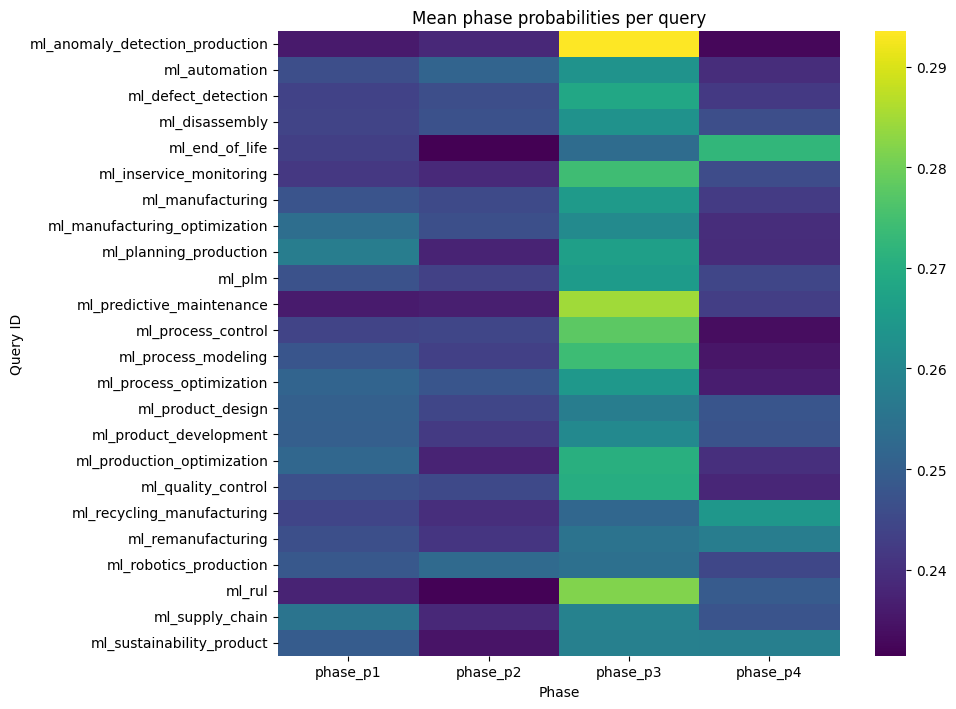

In [ ]:
# Plot heatmap of mean phase probabilities per query_id

import seaborn as sns  # if you are OK adding seaborn

plt.figure(figsize=(10, len(query_phase_means) * 0.3))
sns.heatmap(
    query_phase_means[phase_prob_cols],
    annot=False,
    cmap="viridis",
    cbar=True
)
plt.xlabel("Phase")
plt.ylabel("Query ID")
plt.title("Mean phase probabilities per query")
plt.tight_layout()
plt.show()


In [ ]:
# Show the most confident abstracts for each phase (primary_phase)
cols_show = [
    "query_id", "doi", "primary_phase", "phase_max_prob", "phase_margin",
    "title", "clean_abs"
]

for p in [1, 2, 3, 4]:
    print(f"\nMost confident Phase {p} abstracts\n")
    
    df_phase = df[df["primary_phase"] == p]
    top_conf = df_phase.sort_values("phase_max_prob", ascending=False).head(5)
    
    display(top_conf[cols_show])



Most confident Phase 1 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
27093,ml_planning_production,10.1109/SMC42975.2020.9282869,1,0.300148,0.040592,Neural Combinatorial Optimization for Producti...,One of the main objectives of production plann...
27243,ml_planning_production,10.1007/978-3-030-25719-4_27,1,0.299459,0.055848,Development of an Optimal Production Plan Usin...,The present article is devoted to the problem ...
25274,ml_planning_production,10.1016/j.mfglet.2025.08.005,1,0.298274,0.041036,Technology prediction of a 3D model using neur...,This paper introduces a data-driven approach t...
26733,ml_planning_production,10.1016/j.ifacol.2022.09.305,1,0.297549,0.049247,Predicting makespan in Flexible Job Shop Sched...,This is an open access article under the CC BY...
26201,ml_planning_production,10.1080/00207543.2023.2245918,1,0.296940,0.040097,Makespan estimation in a flexible job-shop sch...,A production plan gives the quantity of produc...



Most confident Phase 2 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
48543,ml_robotics_production,10.1016/j.tre.2021.102273,2,0.285099,0.009855,Novel robotic job-shop scheduling models with ...,With the common assumptions of negligible mate...
14916,ml_manufacturing,10.1016/j.mfglet.2022.08.013,2,0.284449,0.031529,Physics-aware machine learning surrogates for ...,We believe such a real-time digital twin frame...
48609,ml_robotics_production,10.1109/IROS45743.2020.9341666,2,0.284263,0.021663,Automatic synthesis of human motion from tempo...,Humans and robots are increasingly sharing the...
23512,ml_manufacturing_optimization,10.1109/TASE.2023.3320873,2,0.281467,0.028950,Adaptive Safety-Critical Control with Uncertai...,"In advanced manufacturing, strict safety guara..."
34759,ml_process_control,10.1007/978-3-030-49435-3_28,2,0.281426,0.021457,Resource-Based Adaptive Robotic Process Automa...,Robotic process automation is evolving from ro...



Most confident Phase 3 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
20967,ml_manufacturing,10.1145/2184751.2184798,3,0.332371,0.100612,Application case study of machine learning tec...,Fault diagnosis is a vital problem in process ...
32320,ml_process_control,10.1016/j.engappai.2025.111227,3,0.331807,0.098553,Enhanced process monitoring using machine lear...,"g., outliers) in process monitoring is crucial..."
0,ml_anomaly_detection_production,10.1016/j.measurement.2025.119261,3,0.331779,0.108447,Distillation anomaly and fault detection based...,"Indeed, highly efficient systems do not always..."
33850,ml_process_control,10.1109/ICCCS57501.2023.10150495,3,0.331104,0.101622,Anomaly Detection for Process Industry using C...,Anomaly detection is essential to the safety o...
34474,ml_process_control,10.1109/CCDC52312.2021.9601433,3,0.331041,0.096726,A dynamic outlier ensemble for databases in wi...,"In wind tunnel experiments, a portion of abnor..."



Most confident Phase 4 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
3367,ml_end_of_life,10.3390/su17125511,4,0.307245,0.066717,Review and Novel Framework with Hui–Walter Met...,Consumers’ growing interest in sustainability ...
50508,ml_supply_chain,10.1007/978-981-96-3939-7_6,4,0.305435,0.063783,Utilizing Machine Learning for Enhanced Produc...,"2025.Food waste, a pervasive global issue, ref..."
3098,ml_disassembly,10.1038/s41598-024-81741-z,4,0.304258,0.061366,Stakeholder perspectives on the costs and bene...,The construction industry significantly impact...
47896,ml_remanufacturing,10.1016/j.wasman.2014.11.024,4,0.304071,0.051645,An investigation of used electronics return fl...,Consumers often have a tendency to store their...
47881,ml_remanufacturing,10.1016/j.resconrec.2020.105073,4,0.303621,0.060029,The narrative of sustainability and circular e...,The growing popularity of the concept is accom...
